# Predicting the Presence of Heart Disease in Cleveland: <br> Determining the Effects of Age, Cholesterol, and Heart Rate

## Introduction

Heart disease, also known as cardiovascular disease, is the top leading cause of death across the world, according to the [WHO](https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death). Heart disease refers to several heart-affecting conditions, with the most common condition causing blood vessels to narrow, restricting blood flow and potentially leading to heart attack.

The predictive question we wish to answer is: <br>
***“What key factors influence the presence of heart disease, and can we accurately diagnose heart disease based on age, cholesterol levels and maximum heart rate?”***

Through data analysis, we will use the heart disease data set from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/45/heart+disease), collected on June 30, 1988. This data set includes various observations from people in Cleveland, Hungary, Switzerland and the VA Long Beach. We will focus on the ***Cleveland data set*** to answer our question.


## Methods

To predict the presence of heart disease in patients, we will use the K-Nearest Neighbors Classification algorithm to model and classify patients. 

The labels of the Cleveland data set columns are as follows:

1. age: age
2. sex: 0 = Female, 1 = Male
3. cp: chest pain type
4. trestbps: resting blood pressure (mmHg)
5. chol: cholesterol (mg/dL)
6. fbs: fasting blood sugar (1 = high, 0 = normal)
7. restecg: resting electrocardiographic results (0 = Normal, 1 = Abnormal, 2 = Likely Damage)
8. thalach: Maximum heart rate (beats/min)
9. exang: exercise angina (1 = True, 0 = False)
10. oldpeak: ST depression by exercise
11. slope: slope of peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
12. ca: major vessels (#0-3)
13. thal: 3 = normal, 6 = fixed defect, 7 = reversable defect
14. num: diagnosis of heart disease

First, we will load require packages and read the `processed.cleveland.data` from the data set.

In [9]:
# Libraries/Packages to load
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(themis)

ERROR: Error in library(themis): there is no package called ‘themis’


In [10]:
# Reading the data from the web, adding column names
heart_data <- read_csv("https://raw.githubusercontent.com/Mr-Slope/DSCI-100_Group_Project/main/processed.cleveland.data",
                       col_names=c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                   "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
# Preview the data set
head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In the data frame above, `ca` and `thal` are character types despite showing number values, so they should be changed to numbers. However, because R did not automatically convert, we will also use `distinct()` to see if there are hidden character values in those columns.

In [11]:
select(heart_data, ca, thal) |>
distinct()

ca,thal
<chr>,<chr>
0.0,6.0
3.0,3.0
2.0,7.0
0.0,3.0
2.0,3.0
1.0,7.0
0.0,7.0
1.0,6.0
3.0,7.0


Above, we see that there are `?` values, that must be filtered out.

In addition, we know that `sex`, `cp`, `fbs`, `restecg`, `exang`, `slope`, `ca`, `thal`, and `num` should be categorical/factor variables based on the column descriptions. It is also hard to interpret the values of these categorical variables, so we will rename them using `fct_recode()` based on the column descriptions. 

In [12]:
# Cleaning & Wrangling
heart_tidy <- heart_data |>
    filter(ca != "?", thal != "?") |>
    mutate(across(c(ca, thal), as.numeric)) |>
    mutate(across(c(sex, cp, fbs, restecg, exang, slope, ca, thal, num), as_factor)) |>
    mutate(sex = fct_recode(sex, "male" = "1", "female" = "0")) |>
    mutate(cp = fct_recode(cp, "angina" = "1", "abnormal" = "2", "nonang" = "3", "asymp" = "4")) |>
    mutate(fbs = fct_recode(fbs, "high" = "1", "norm" = "0")) |>
    mutate(restecg = fct_recode(restecg, "norm" = "0", "abnorm" = "1", "damage" = "2")) |>
    mutate(exang = fct_recode(exang, "TRUE" = "1", "FALSE" = "0")) |>
    mutate(slope = fct_recode(slope, "up" = "1", "flat" = "2", "down" = "3")) |>
    mutate(thal = fct_recode(thal, "norm" = "3", "fixed" = "6", "reversible" = "7")) |>
    mutate(num = fct_recode(num, "healthy" = "0", "sick" = "1", "sick" = "2", "sick" = "3", "sick" = "4")) |> # in the data files, 1,2,3,4 are all sick
    tibble() 

# Splitting the data (separate this)
heart_split <- initial_split(heart_tidy, prop = 0.75, strata = num)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

head(heart_training)

# Summary Statistics (remove?)
heart_min_max <- heart_training |>
    select(age, trestbps, chol, thalach, oldpeak, num) |>    
    group_by(num) |>
    summarize(min_age = min(age), max_age = max(age), mean_age = mean(age),
              min_trestbps = min(trestbps), max_trestbps = max(trestbps),
              min_chol = min(chol), max_chol = max(chol), 
              min_thalach = min(thalach), max_thalach = max(thalach),
              min_oldpeak = min(oldpeak), max_oldpeak = max(oldpeak),
              count = n())

heart_summary_sex <- heart_training |>
    group_by(sex) |>
    summarize(count = n())

heart_min_max
heart_summary_sex


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,male,angina,145,233,high,damage,150,FALSE,2.3,down,0,fixed,healthy
37,male,nonang,130,250,norm,norm,187,FALSE,3.5,down,0,norm,healthy
56,male,abnormal,120,236,norm,norm,178,FALSE,0.8,up,0,norm,healthy
57,female,asymp,120,354,norm,norm,163,TRUE,0.6,up,0,norm,healthy
56,female,abnormal,140,294,norm,damage,153,FALSE,1.3,flat,0,norm,healthy
44,male,abnormal,120,263,norm,norm,173,FALSE,0.0,up,0,reversible,healthy


num,min_age,max_age,mean_age,min_trestbps,max_trestbps,min_chol,max_chol,min_thalach,max_thalach,min_oldpeak,max_oldpeak,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
healthy,29,76,53.02500,94,180,126,564,96,202,0,4.2,120
sick,35,77,57.09804,100,192,149,407,71,195,0,5.6,102


sex,count
<fct>,<int>
female,69
male,153


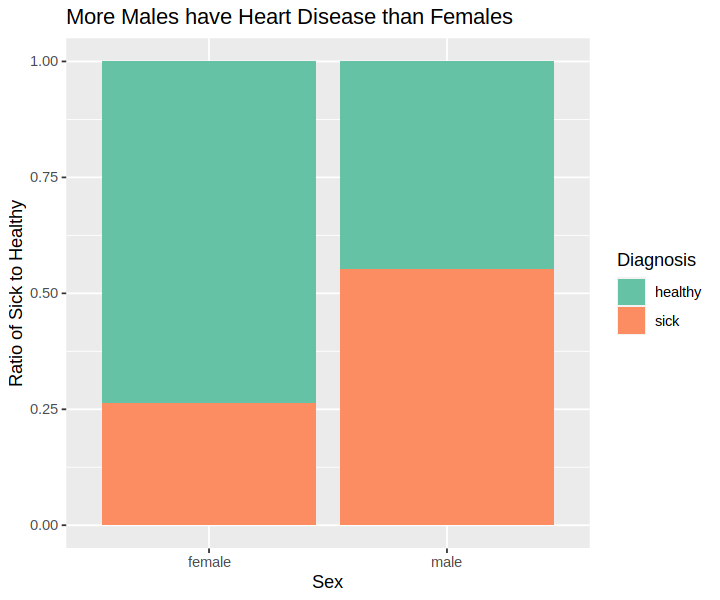

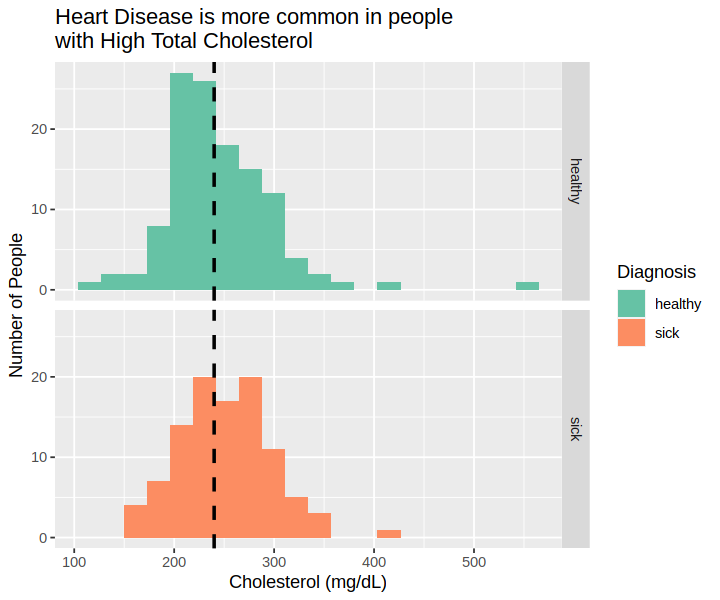

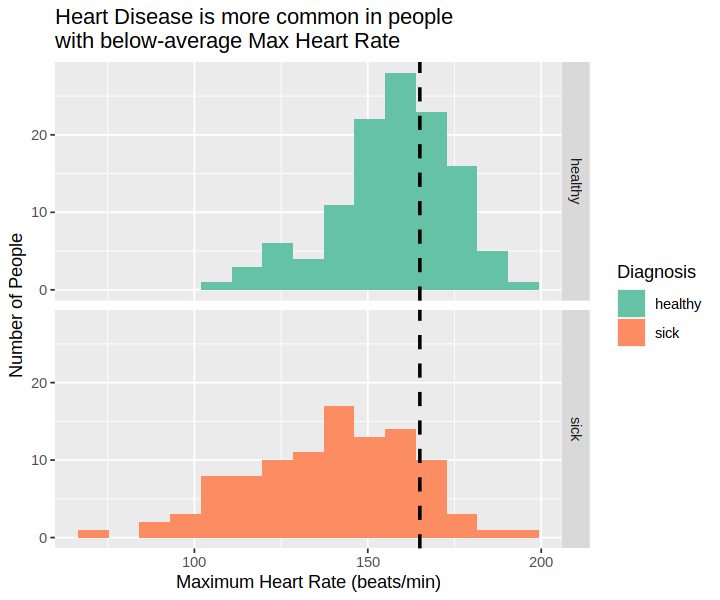

In [3]:
# Visualizations of Key Predictor Variables
options(repr.plot.width = 6, repr.plot.height = 5)

# Male to Female ratios b/w Sick & Healthy (Age)
male_female <- heart_training |>
    ggplot(aes(x=sex,fill=num)) +
    geom_bar(position="fill") +
    labs(x="Sex", y="Ratio of Sick to Healthy", fill="Diagnosis",
         title="More Males have Heart Disease than Females") +
    scale_fill_brewer(palette = "Set2")
male_female

# Dangerous Total Cholesterol is 240 mg/dL and above for adults 20 years old and over
# Higher cholesterol may lead to higher risk
chol_histogram <- heart_training |>
    ggplot(aes(x = chol, fill=num)) +
    geom_histogram(bins=20) +
    facet_grid(rows = vars(num)) +
    geom_vline(xintercept = 240, linetype = "dashed", linewidth = 1.0) +
    labs(x="Cholesterol (mg/dL)", fill="Diagnosis", y="Number of People",
        title="Heart Disease is more common in people \nwith High Total Cholesterol") +
    scale_fill_brewer(palette = "Set2")
chol_histogram

# Average Max heart rate for the mean age of 55 is 165 beats per min
# Below-average Max Heart Rate signifies poor circulation, increasing risk
trestbps_histogram <- heart_training |>
    ggplot(aes(x = thalach, fill=num)) +
    geom_histogram(bins=15) +
    facet_grid(rows = vars(num)) +
    geom_vline(xintercept = 165, linetype = "dashed", linewidth = 1.0) +
    labs(x="Maximum Heart Rate (beats/min)", fill="Diagnosis", y="Number of People",
         title="Heart Disease is more common in people \nwith below-average Max Heart Rate") +
    scale_fill_brewer(palette = "Set2")
trestbps_histogram

## Expected outcomes and significance:

We expect [Resting Electrocardiographic](https://www.ncbi.nlm.nih.gov/books/NBK367910/#.) (restecg), [Exercise Induced Angina](https://www.ahajournals.org/doi/full/10.1161/01.CIR.0000060545.09308.F5#) and [ST Depression induced by exercise](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1768611/#) to be some of the key indicators of heart disease. Furthermore, we expect cholesterol levels, maximum heart rate and blood pressure to be rather accurate predictors of blood pressure as the higher they are, the higher the chances of someone having a heart disease.

These findings have the potential to enhance public health through targeted prevention efforts, reducing the impact of heart disease and dispelling misconceptions for appropriate treatments overall. Furthermore, identifying relationships between each variables (age, sex, and risk factors) can lead to earlier treatments.

Future questions include the effects of varying demographic groups, as diverse lifestyles and dietary habits can be key predictors for heart disease.

## Bibiliography

